In [1]:
from sklearn.datasets import load_svmlight_file, make_classification
from sklearn.model_selection import train_test_split

import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import trange
import time

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Helpers

In [3]:
def logreg_grad(w, X, y):
    '''
    Numpy computation for gradient of logistic regression

    Params:
    -------
    w : array
        weights of ridge
    X : array
        Dataset
    y : array
        labels
    l : float
        lambda parameter for ridge
    mode : string
           In which mode to compute logreg: None, 'lasso' or 'ridge'
    '''
    y_pred = 1/ (1 + np.exp(-X @ w))
    g = np.dot(X.T, (y_pred - y)) / len(y)
    return g

In [4]:
def init_M(X, y, LMO, R):
    eps = 1e-3
    w = np.zeros(X.shape[-1])
    grad = logreg_grad(w, X, y)
    s = LMO(grad, w, R)
    d_0 = s - w
    grad_update = logreg_grad(w + eps * d_0, X, y)
    M = np.linalg.norm(grad - grad_update) / (eps * np.linalg.norm(d_0))
    return M

In [5]:
def make_experiment(exp_params):
    xt = exp_params['x0']
    X = exp_params['X']
    y = exp_params['y']
    objectives = []
    times = []
    start = time.time()

    for i in trange(exp_params['n_iter']):
        grad = logreg_grad(xt, X, y)
        st = exp_params['LMO'](-grad, xt, exp_params['R'])
        dt = st - xt
        gt = np.dot(-grad, dt)
        gamma = exp_params['gamma_step'](gt, dt, L, i, exp_params, xt)
        xt = xt + gamma * dt

        objectives.append(exp_params['objective'](xt, X, y))
        times.append(time.time() - start)

    return objectives, times

In [6]:
def L_constant(X, l=0):
    '''
    Estimation of the Lipschitz constant

    Params:
    -------
    X : array
        Dataset
    l : float
        lambda parameter for ridge
    '''
    X_norm = np.sum([np.linalg.norm(x) ** 2 for x in X]) / (4 * X.shape[0])
    return X_norm + l

In [7]:
def loss_logreg(w, X, y):
    y_pred = 1/ (1 + np.exp(-X @ w))
    loss = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)).mean()
    return loss

##Datasets preparation


### Mushrooms

In [8]:
dataset = "/content/gdrive/MyDrive/Skoltech/mushrooms.txt"


data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]

y = y - 1
mushrooms_train, mushrooms_test, mushrooms_y_train, mushrooms_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

L = L_constant(mushrooms_train)
L

5.25

###Synthetic normal

In [9]:
X, y = make_classification(
    n_samples=5000,
    n_features=50,
    n_informative=2,
    class_sep=1,
    random_state=17,
)

normal_train, normal_test, normal_y_train, normal_y_test = train_test_split(X, y, test_size=0.2, random_state=17)

L = L_constant(normal_train)
L

12.60594349952399

###Synthetic high dimensional

In [10]:
X, y = make_classification(
    n_samples=5000,
    n_features=1024,
    n_informative=3,
    class_sep=1,
    random_state=17,
)

dim_train, dim_test, dim_y_train, dim_y_test = train_test_split(X, y, test_size=0.2, random_state=17)

L = L_constant(dim_train)
L

257.7497456427287

###Synthetic ill conditioned

In [11]:
X, y = make_classification(
    n_samples=5000,
    n_features=50,
    n_informative=5,
    class_sep=20,
    random_state=17,
)

ill_train, ill_test, ill_y_train, ill_y_test = train_test_split(X, y, test_size=0.2, random_state=17)

L = L_constant(ill_train)
L

873.7288357477153

##Gamma steps

In [12]:
def trivial(gt, dt, L, i, exp_params, xt):
    return 2 / (i + 10)

def demyanov_rubinov(gt, dt, L, i, exp_params, xt):
    return min(1, gt / (L * np.linalg.norm(dt) ** 2))

def Q(f, gamma, g_t, M, d):
    return f - gamma * g_t + gamma ** 2 * M * np.linalg.norm(d) ** 2 / 2

def backtracking_line_search(gt, dt, L, i, exp_params, xt):
    Mt = exp_params['Mt']
    Mt = Mt * 0.9
    X = exp_params['X']
    y = exp_params['y']
    gamma = min(1, gt / (Mt * np.linalg.norm(dt) ** 2))
    while exp_params['objective'](xt + gamma * dt, X, y) > Q(exp_params['objective'](xt, X, y), gamma, gt, Mt, dt):
        Mt = 2 * Mt
    exp_params['Mt'] = Mt
    return gamma


def armijo(gt, dt, L, i, exp_params, xt):
    X = exp_params['X']
    y = exp_params['y']
    # передаю альфу для инициализации
    alpha = exp_params['alpha_init']

    while (exp_params['objective'](xt + alpha * dt, X, y) - exp_params['objective'](xt, X, y)) > -1e-4 * alpha * gt:
        alpha /= 2

    exp_params['alpha_init'] = alpha
    return alpha

##LMOS

In [13]:
def LMO_L1(g, z, R=1.0):
    '''
    Linear Maximization Oracle for l1
    '''
    i = np.argmax(np.abs(g))
    s = np.zeros_like(z)
    s[i] = R * np.sign(g[i])
    return s

def LMO_L2(g, z, R=1.0):
    '''
    Linear Maximization Oracle for l2
    '''
    return R * g / np.linalg.norm(g)

##Experiments

###Normal

In [15]:
trivial_exp_normal = {
    'X': normal_train,
    'y': normal_y_train,
    'x0': np.zeros(normal_train.shape[-1]) + 1e-2,
    'LMO': LMO_L1,
    'R': 100,
    'gamma_step': trivial,
    'objective': loss_logreg,
    'n_iter': 20000,
}
losses_trivial, times_trivial = make_experiment(trivial_exp_normal)

dr_exp_normal = {
    'X': normal_train,
    'y': normal_y_train,
    'x0': np.zeros(normal_train.shape[-1]) + 1e-2,
    'LMO': LMO_L1,
    'R': 100,
    'gamma_step': demyanov_rubinov,
    'objective': loss_logreg,
    'n_iter': 20000,
}
losses_dr, times_dr = make_experiment(dr_exp_normal)

ls_exp_normal = {
    'X': normal_train,
    'y': normal_y_train,
    'x0': np.zeros(normal_train.shape[-1]) + 1e-2,
    'LMO': LMO_L1,
    'R': 100,
    'gamma_step': backtracking_line_search,
    'objective': loss_logreg,
    'n_iter': 20000,
    'Mt': init_M(normal_train, normal_y_train, LMO_L1, 100)
}
losses_ls, times_ls = make_experiment(ls_exp_normal)

armijo_exp_normal = {
    'X': normal_train,
    'y': normal_y_train,
    'x0': np.zeros(normal_train.shape[-1]) + 1e-2,
    'LMO': LMO_L1,
    'R': 100,
    'gamma_step': armijo,
    'objective': loss_logreg,
    'n_iter': 20000,
    'alpha_init': 1/16,
}
losses_armijo, times_armigo = make_experiment(armijo_exp_normal)

  0%|          | 0/20000 [00:00<?, ?it/s]<ipython-input-7-d79be08c2ece>:3: RuntimeWarning: divide by zero encountered in log
  loss = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)).mean()
<ipython-input-7-d79be08c2ece>:3: RuntimeWarning: invalid value encountered in multiply
  loss = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)).mean()
100%|██████████| 20000/20000 [01:21<00:00, 244.85it/s]


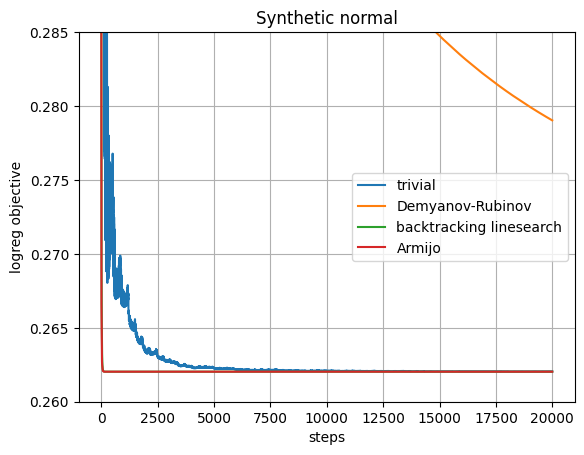

In [23]:
plt.title('Synthetic normal')
plt.plot(losses_trivial, label='trivial')
plt.plot(losses_dr, label='Demyanov-Rubinov')
plt.plot(losses_ls, label='backtracking linesearch')
plt.plot(losses_armijo, label='Armijo')
plt.legend()
plt.grid()
plt.xlabel('steps')
plt.ylabel('logreg objective')
plt.ylim(0.26, 0.285)
plt.show();

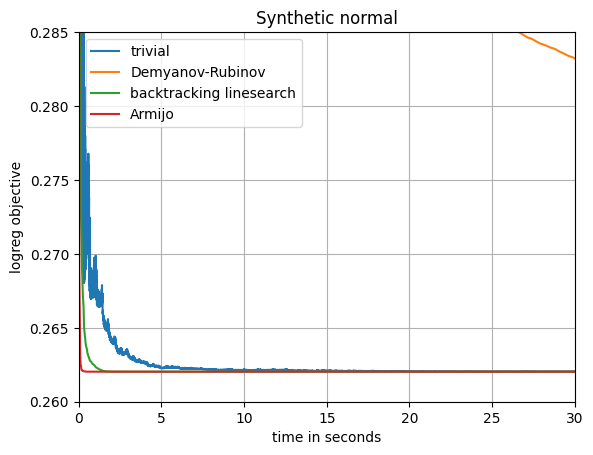

In [25]:
plt.title('Synthetic normal')
plt.plot(times_trivial, losses_trivial, label='trivial')
plt.plot(times_dr, losses_dr, label='Demyanov-Rubinov')
plt.plot(times_ls, losses_ls, label='backtracking linesearch')
plt.plot(times_armigo, losses_armijo, label='Armijo')
plt.legend()
plt.grid()
plt.xlabel('time in seconds')
plt.ylabel('logreg objective')
plt.ylim(0.26, 0.285)
plt.xlim(0, 30)
plt.show();

In [63]:
trivial_exp_normal = {
    'X': normal_train,
    'y': normal_y_train,
    'x0': np.zeros(normal_train.shape[-1]) + 1e-2,
    'LMO': LMO_L2,
    'R': 100,
    'gamma_step': trivial,
    'objective': loss_logreg,
    'n_iter': 20000,
}
losses_trivial, times_trivial = make_experiment(trivial_exp_normal)

dr_exp_normal = {
    'X': normal_train,
    'y': normal_y_train,
    'x0': np.zeros(normal_train.shape[-1]) + 1e-2,
    'LMO': LMO_L2,
    'R': 100,
    'gamma_step': demyanov_rubinov,
    'objective': loss_logreg,
    'n_iter': 20000,
}
losses_dr, times_dr = make_experiment(dr_exp_normal)

ls_exp_normal = {
    'X': normal_train,
    'y': normal_y_train,
    'x0': np.zeros(normal_train.shape[-1]) + 1e-2,
    'LMO': LMO_L2,
    'R': 100,
    'gamma_step': backtracking_line_search,
    'objective': loss_logreg,
    'n_iter': 20000,
    'Mt': init_M(normal_train, normal_y_train, LMO_L1, 100)
}
losses_ls, times_ls = make_experiment(ls_exp_normal)

armijo_exp_normal = {
    'X': normal_train,
    'y': normal_y_train,
    'x0': np.zeros(normal_train.shape[-1]) + 1e-2,
    'LMO': LMO_L2,
    'R': 100,
    'gamma_step': armijo,
    'objective': loss_logreg,
    'n_iter': 20000,
    'alpha_init': 1/16,
}
losses_armijo, times_armigo = make_experiment(armijo_exp_normal)

  0%|          | 0/20000 [00:00<?, ?it/s]<ipython-input-7-d79be08c2ece>:3: RuntimeWarning: divide by zero encountered in log
  loss = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)).mean()
<ipython-input-7-d79be08c2ece>:3: RuntimeWarning: invalid value encountered in multiply
  loss = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)).mean()
100%|██████████| 20000/20000 [01:01<00:00, 326.57it/s]


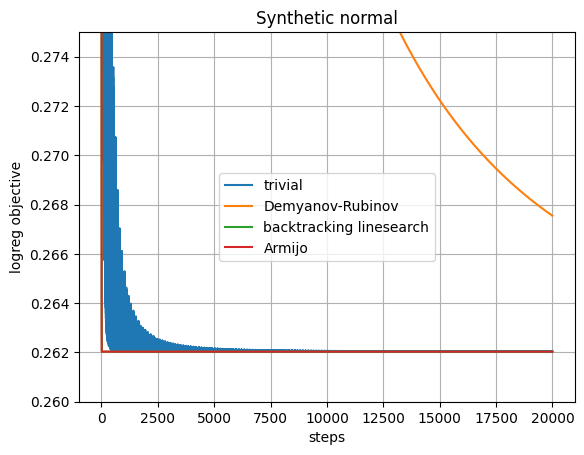

In [66]:
plt.title('Synthetic normal')
plt.plot(losses_trivial, label='trivial')
plt.plot(losses_dr, label='Demyanov-Rubinov')
plt.plot(losses_ls, label='backtracking linesearch')
plt.plot(losses_armijo, label='Armijo')
plt.legend()
plt.grid()
plt.xlabel('steps')
plt.ylabel('logreg objective')
plt.ylim(0.26, 0.275)
plt.show();

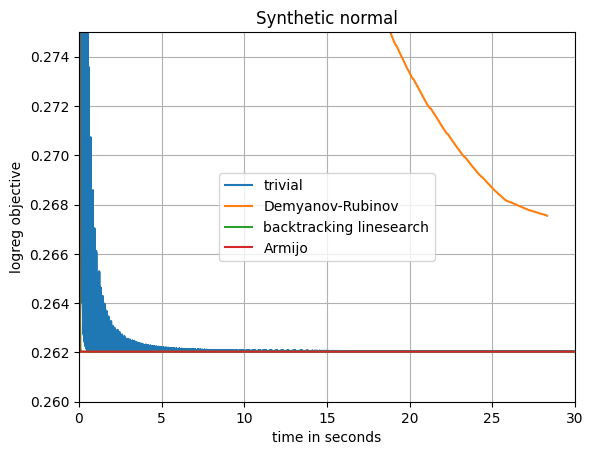

In [67]:
plt.title('Synthetic normal')
plt.plot(times_trivial, losses_trivial, label='trivial')
plt.plot(times_dr, losses_dr, label='Demyanov-Rubinov')
plt.plot(times_ls, losses_ls, label='backtracking linesearch')
plt.plot(times_armigo, losses_armijo, label='Armijo')
plt.legend()
plt.grid()
plt.xlabel('time in seconds')
plt.ylabel('logreg objective')
plt.ylim(0.26, 0.275)
plt.xlim(0, 30)
plt.show();

###High dimensional

In [60]:
trivial_exp_normal = {
    'X': dim_train,
    'y': dim_y_train,
    'x0': np.zeros(dim_train.shape[-1]) + 1e-2,
    'LMO': LMO_L1,
    'R': 100,
    'gamma_step': trivial,
    'objective': loss_logreg,
    'n_iter': 10000,
}
losses_trivial, times_trivial = make_experiment(trivial_exp_normal)

dr_exp_normal = {
    'X': dim_train,
    'y': dim_y_train,
    'x0': np.zeros(dim_train.shape[-1]) + 1e-2,
    'LMO': LMO_L1,
    'R': 100,
    'gamma_step': demyanov_rubinov,
    'objective': loss_logreg,
    'n_iter': 10000,
}
losses_dr, times_dr = make_experiment(dr_exp_normal)

ls_exp_normal = {
    'X': dim_train,
    'y': dim_y_train,
    'x0': np.zeros(dim_train.shape[-1]) + 1e-2,
    'LMO': LMO_L1,
    'R': 100,
    'gamma_step': backtracking_line_search,
    'objective': loss_logreg,
    'n_iter': 10000,
    'Mt': init_M(dim_train, dim_y_train, LMO_L1, 100)
}
losses_ls, times_ls = make_experiment(ls_exp_normal)

armijo_exp_normal = {
    'X': dim_train,
    'y': dim_y_train,
    'x0': np.zeros(dim_train.shape[-1]) + 1e-2,
    'LMO': LMO_L1,
    'R': 100,
    'gamma_step': armijo,
    'objective': loss_logreg,
    'n_iter': 10000,
    'alpha_init': 1/16,
}
losses_armijo, times_armigo = make_experiment(armijo_exp_normal)

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-7-d79be08c2ece>:3: RuntimeWarning: divide by zero encountered in log
  loss = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)).mean()
<ipython-input-7-d79be08c2ece>:3: RuntimeWarning: invalid value encountered in multiply
  loss = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)).mean()
100%|██████████| 10000/10000 [08:00<00:00, 20.81it/s]


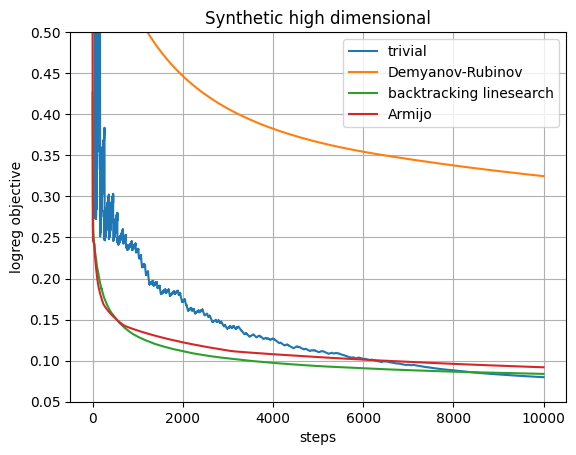

In [61]:
plt.title('Synthetic high dimensional')
plt.plot(losses_trivial, label='trivial')
plt.plot(losses_dr, label='Demyanov-Rubinov')
plt.plot(losses_ls, label='backtracking linesearch')
plt.plot(losses_armijo, label='Armijo')
plt.legend()
plt.grid()
plt.xlabel('steps')
plt.ylabel('logreg objective')
plt.ylim(0.05, 0.5)
plt.show();

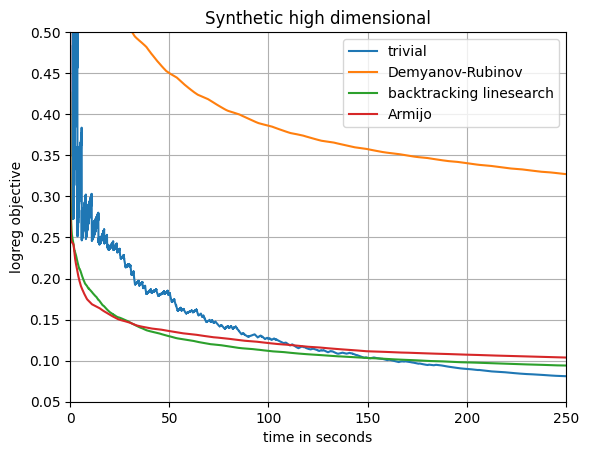

In [62]:
plt.title('Synthetic high dimensional')
plt.plot(times_trivial, losses_trivial, label='trivial')
plt.plot(times_dr, losses_dr, label='Demyanov-Rubinov')
plt.plot(times_ls, losses_ls, label='backtracking linesearch')
plt.plot(times_armigo, losses_armijo, label='Armijo')
plt.legend()
plt.grid()
plt.xlabel('time in seconds')
plt.ylabel('logreg objective')
plt.ylim(0.05, 0.5)
plt.xlim(0, 250)
plt.show();

In [73]:
trivial_exp_normal = {
    'X': dim_train,
    'y': dim_y_train,
    'x0': np.zeros(dim_train.shape[-1]) + 1e-2,
    'LMO': LMO_L2,
    'R': 10,
    'gamma_step': trivial,
    'objective': loss_logreg,
    'n_iter': 10000,
}
losses_trivial, times_trivial = make_experiment(trivial_exp_normal)

dr_exp_normal = {
    'X': dim_train,
    'y': dim_y_train,
    'x0': np.zeros(dim_train.shape[-1]) + 1e-2,
    'LMO': LMO_L2,
    'R': 10,
    'gamma_step': demyanov_rubinov,
    'objective': loss_logreg,
    'n_iter': 10000,
}
losses_dr, times_dr = make_experiment(dr_exp_normal)

ls_exp_normal = {
    'X': dim_train,
    'y': dim_y_train,
    'x0': np.zeros(dim_train.shape[-1]) + 1e-2,
    'LMO': LMO_L2,
    'R': 10,
    'gamma_step': backtracking_line_search,
    'objective': loss_logreg,
    'n_iter': 10000,
    'Mt': init_M(dim_train, dim_y_train, LMO_L1, 100)
}
losses_ls, times_ls = make_experiment(ls_exp_normal)

armijo_exp_normal = {
    'X': dim_train,
    'y': dim_y_train,
    'x0': np.zeros(dim_train.shape[-1]) + 1e-2,
    'LMO': LMO_L2,
    'R': 10,
    'gamma_step': armijo,
    'objective': loss_logreg,
    'n_iter': 10000,
    'alpha_init': 1/32,
}
losses_armijo, times_armigo = make_experiment(armijo_exp_normal)

  9%|▉         | 922/10000 [00:22<05:00, 30.19it/s]<ipython-input-7-d79be08c2ece>:3: RuntimeWarning: divide by zero encountered in log
  loss = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)).mean()
<ipython-input-7-d79be08c2ece>:3: RuntimeWarning: invalid value encountered in multiply
  loss = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)).mean()
100%|██████████| 10000/10000 [08:00<00:00, 20.79it/s]


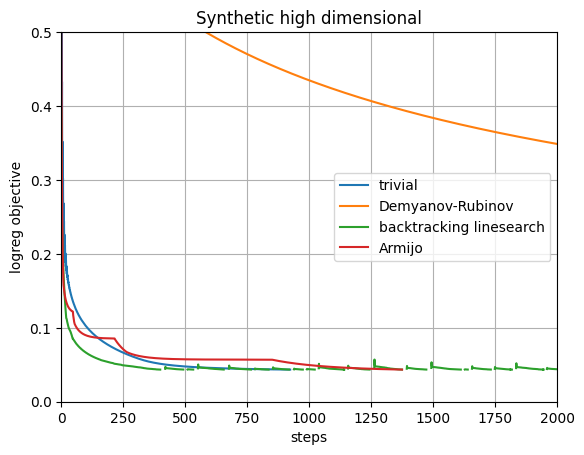

In [77]:
plt.title('Synthetic high dimensional')
plt.plot(losses_trivial, label='trivial')
plt.plot(losses_dr, label='Demyanov-Rubinov')
plt.plot(losses_ls, label='backtracking linesearch')
plt.plot(losses_armijo, label='Armijo')
plt.legend()
plt.grid()
plt.xlabel('steps')
plt.ylabel('logreg objective')
plt.ylim(0, 0.5)
plt.xlim(0, 2000)
plt.show();

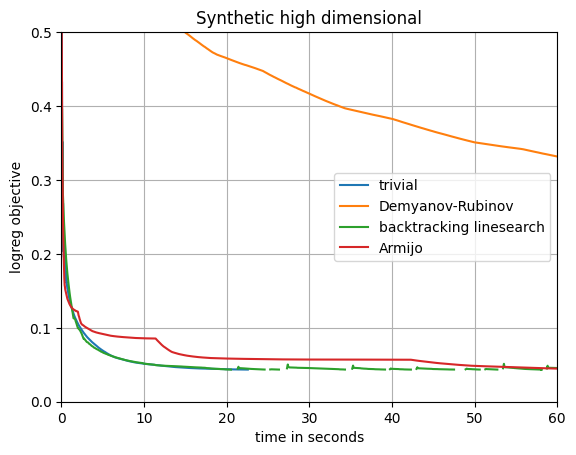

In [79]:
plt.title('Synthetic high dimensional')
plt.plot(times_trivial, losses_trivial, label='trivial')
plt.plot(times_dr, losses_dr, label='Demyanov-Rubinov')
plt.plot(times_ls, losses_ls, label='backtracking linesearch')
plt.plot(times_armigo, losses_armijo, label='Armijo')
plt.legend()
plt.grid()
plt.xlabel('time in seconds')
plt.ylabel('logreg objective')
plt.ylim(0, 0.5)
plt.xlim(0, 60)
plt.show();

###Ill conditioned

In [40]:
trivial_exp_normal = {
    'X': ill_train,
    'y': ill_y_train,
    'x0': np.zeros(ill_train.shape[-1]) + 1e-2,
    'LMO': LMO_L1,
    'R': 500,
    'gamma_step': trivial,
    'objective': loss_logreg,
    'n_iter': 30000,
}
losses_trivial, times_trivial = make_experiment(trivial_exp_normal)

dr_exp_normal = {
    'X': ill_train,
    'y': ill_y_train,
    'x0': np.zeros(ill_train.shape[-1]) + 1e-2,
    'LMO': LMO_L1,
    'R': 500,
    'gamma_step': demyanov_rubinov,
    'objective': loss_logreg,
    'n_iter': 30000,
}
losses_dr, times_dr = make_experiment(dr_exp_normal)

ls_exp_normal = {
    'X': ill_train,
    'y': ill_y_train,
    'x0': np.zeros(ill_train.shape[-1]) + 1e-2,
    'LMO': LMO_L1,
    'R': 500,
    'gamma_step': backtracking_line_search,
    'objective': loss_logreg,
    'n_iter': 30000,
    'Mt': init_M(ill_train, ill_y_train, LMO_L1, 500)
}
losses_ls, times_ls = make_experiment(ls_exp_normal)

  0%|          | 0/30000 [00:00<?, ?it/s]<ipython-input-7-d79be08c2ece>:2: RuntimeWarning: overflow encountered in exp
  y_pred = 1/ (1 + np.exp(-X @ w))
<ipython-input-7-d79be08c2ece>:3: RuntimeWarning: divide by zero encountered in log
  loss = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)).mean()
<ipython-input-7-d79be08c2ece>:3: RuntimeWarning: invalid value encountered in multiply
  loss = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)).mean()
<ipython-input-3-ded88a270672>:18: RuntimeWarning: overflow encountered in exp
  y_pred = 1/ (1 + np.exp(-X @ w))
100%|██████████| 30000/30000 [01:33<00:00, 320.39it/s]


In [52]:
armijo_exp_normal = {
    'X': ill_train,
    'y': ill_y_train,
    'x0': np.zeros(ill_train.shape[-1]) + 1e-2,
    'LMO': LMO_L1,
    'R': 500,
    'gamma_step': armijo,
    'objective': loss_logreg,
    'n_iter': 30000,
    'alpha_init': 1/1024,
}
losses_armijo, times_armigo = make_experiment(armijo_exp_normal)

100%|██████████| 30000/30000 [01:33<00:00, 320.75it/s]


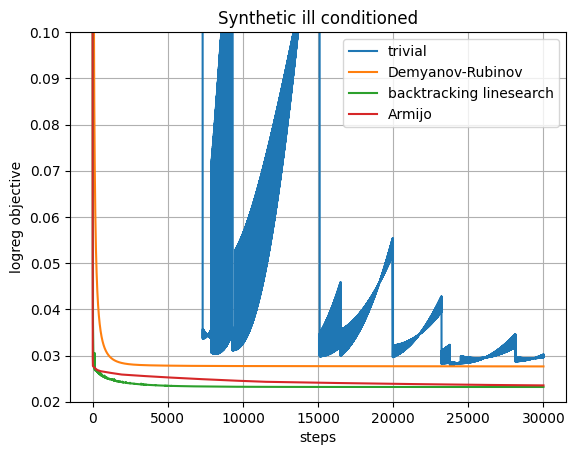

In [55]:
plt.title('Synthetic ill conditioned')
plt.plot(losses_trivial, label='trivial')
plt.plot(losses_dr, label='Demyanov-Rubinov')
plt.plot(losses_ls, label='backtracking linesearch')
plt.plot(losses_armijo, label='Armijo')
plt.legend()
plt.grid()
plt.xlabel('steps')
plt.ylabel('logreg objective')
plt.ylim(0.02, 0.10)
plt.show();

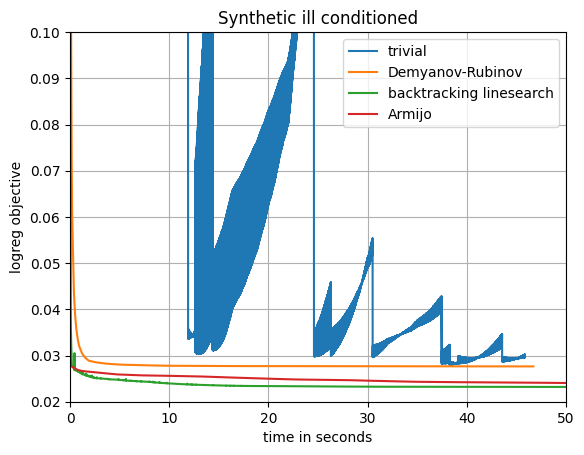

In [56]:
plt.title('Synthetic ill conditioned')
plt.plot(times_trivial, losses_trivial, label='trivial')
plt.plot(times_dr, losses_dr, label='Demyanov-Rubinov')
plt.plot(times_ls, losses_ls, label='backtracking linesearch')
plt.plot(times_armigo, losses_armijo, label='Armijo')
plt.legend()
plt.grid()
plt.xlabel('time in seconds')
plt.ylabel('logreg objective')
plt.ylim(0.02, 0.10)
plt.xlim(0, 50)
plt.show();

In [81]:
trivial_exp_normal = {
    'X': ill_train,
    'y': ill_y_train,
    'x0': np.zeros(ill_train.shape[-1]) + 1e-2,
    'LMO': LMO_L2,
    'R': 100,
    'gamma_step': trivial,
    'objective': loss_logreg,
    'n_iter': 30000,
}
losses_trivial, times_trivial = make_experiment(trivial_exp_normal)

dr_exp_normal = {
    'X': ill_train,
    'y': ill_y_train,
    'x0': np.zeros(ill_train.shape[-1]) + 1e-2,
    'LMO': LMO_L2,
    'R': 100,
    'gamma_step': demyanov_rubinov,
    'objective': loss_logreg,
    'n_iter': 30000,
}
losses_dr, times_dr = make_experiment(dr_exp_normal)

ls_exp_normal = {
    'X': ill_train,
    'y': ill_y_train,
    'x0': np.zeros(ill_train.shape[-1]) + 1e-2,
    'LMO': LMO_L2,
    'R': 100,
    'gamma_step': backtracking_line_search,
    'objective': loss_logreg,
    'n_iter': 30000,
    'Mt': init_M(ill_train, ill_y_train, LMO_L1, 100)
}
losses_ls, times_ls = make_experiment(ls_exp_normal)

armijo_exp_normal = {
    'X': ill_train,
    'y': ill_y_train,
    'x0': np.zeros(ill_train.shape[-1]) + 1e-2,
    'LMO': LMO_L2,
    'R': 100,
    'gamma_step': armijo,
    'objective': loss_logreg,
    'n_iter': 30000,
    'alpha_init': 1/1024,
}
losses_armijo, times_armigo = make_experiment(armijo_exp_normal)

  0%|          | 0/30000 [00:00<?, ?it/s]<ipython-input-7-d79be08c2ece>:3: RuntimeWarning: divide by zero encountered in log
  loss = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)).mean()
<ipython-input-7-d79be08c2ece>:3: RuntimeWarning: invalid value encountered in multiply
  loss = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)).mean()
<ipython-input-7-d79be08c2ece>:2: RuntimeWarning: overflow encountered in exp
  y_pred = 1/ (1 + np.exp(-X @ w))
<ipython-input-3-ded88a270672>:18: RuntimeWarning: overflow encountered in exp
  y_pred = 1/ (1 + np.exp(-X @ w))
100%|██████████| 30000/30000 [01:38<00:00, 304.00it/s]


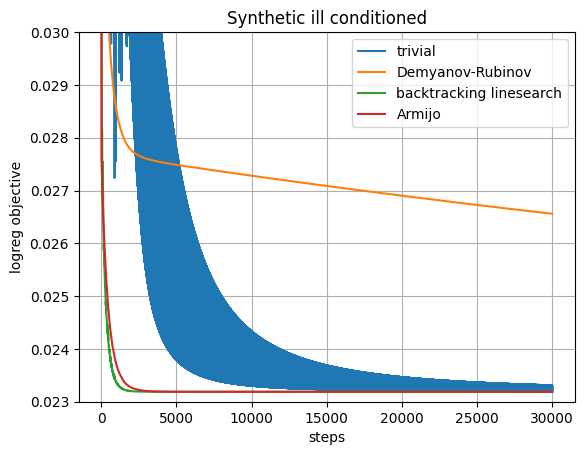

In [86]:
plt.title('Synthetic ill conditioned')
plt.plot(losses_trivial, label='trivial')
plt.plot(losses_dr, label='Demyanov-Rubinov')
plt.plot(losses_ls, label='backtracking linesearch')
plt.plot(losses_armijo, label='Armijo')
plt.legend()
plt.grid()
plt.xlabel('steps')
plt.ylabel('logreg objective')
plt.ylim(0.023, 0.03)
plt.show();

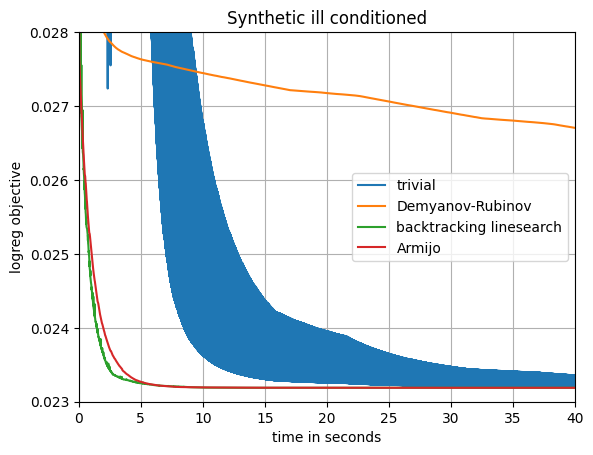

In [89]:
plt.title('Synthetic ill conditioned')
plt.plot(times_trivial, losses_trivial, label='trivial')
plt.plot(times_dr, losses_dr, label='Demyanov-Rubinov')
plt.plot(times_ls, losses_ls, label='backtracking linesearch')
plt.plot(times_armigo, losses_armijo, label='Armijo')
plt.legend()
plt.grid()
plt.xlabel('time in seconds')
plt.ylabel('logreg objective')
plt.ylim(0.023, 0.028)
plt.xlim(0, 40)
plt.show();

###Mushrooms

In [57]:
trivial_exp_normal = {
    'X': mushrooms_train,
    'y': mushrooms_y_train,
    'x0': np.zeros(mushrooms_train.shape[-1]) + 1e-2,
    'LMO': LMO_L1,
    'R': 100,
    'gamma_step': trivial,
    'objective': loss_logreg,
    'n_iter': 50000,
}
losses_trivial, times_trivial = make_experiment(trivial_exp_normal)

dr_exp_normal = {
    'X': mushrooms_train,
    'y': mushrooms_y_train,
    'x0': np.zeros(mushrooms_train.shape[-1]) + 1e-2,
    'LMO': LMO_L1,
    'R': 100,
    'gamma_step': demyanov_rubinov,
    'objective': loss_logreg,
    'n_iter': 50000,
}
losses_dr, times_dr = make_experiment(dr_exp_normal)

ls_exp_normal = {
    'X': mushrooms_train,
    'y': mushrooms_y_train,
    'x0': np.zeros(mushrooms_train.shape[-1]) + 1e-2,
    'LMO': LMO_L1,
    'R': 100,
    'gamma_step': backtracking_line_search,
    'objective': loss_logreg,
    'n_iter': 50000,
    'Mt': init_M(mushrooms_train, mushrooms_y_train, LMO_L1, 100)
}
losses_ls, times_ls = make_experiment(ls_exp_normal)

armijo_exp_normal = {
    'X': mushrooms_train,
    'y': mushrooms_y_train,
    'x0': np.zeros(mushrooms_train.shape[-1]) + 1e-2,
    'LMO': LMO_L1,
    'R': 100,
    'gamma_step': armijo,
    'objective': loss_logreg,
    'n_iter': 50000,
    'alpha_init': 1/32,
}
losses_armijo, times_armigo = make_experiment(armijo_exp_normal)

100%|██████████| 50000/50000 [06:47<00:00, 122.74it/s]


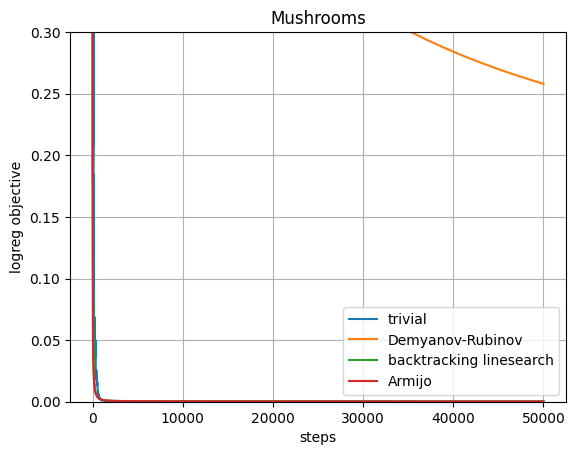

In [58]:
plt.title('Mushrooms')
plt.plot(losses_trivial, label='trivial')
plt.plot(losses_dr, label='Demyanov-Rubinov')
plt.plot(losses_ls, label='backtracking linesearch')
plt.plot(losses_armijo, label='Armijo')
plt.legend()
plt.grid()
plt.xlabel('steps')
plt.ylabel('logreg objective')
plt.ylim(0, 0.3)
plt.show();

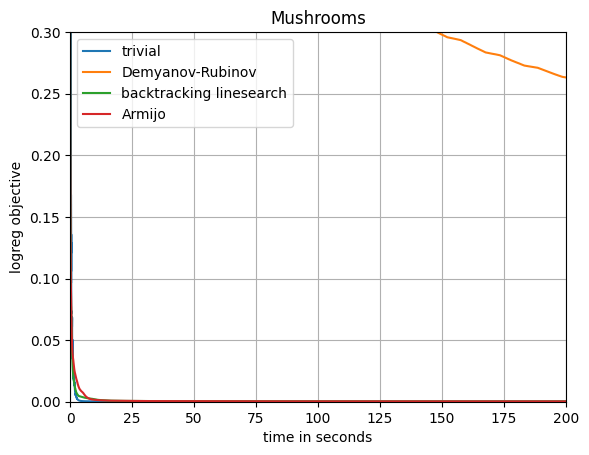

In [59]:
plt.title('Mushrooms')
plt.plot(times_trivial, losses_trivial, label='trivial')
plt.plot(times_dr, losses_dr, label='Demyanov-Rubinov')
plt.plot(times_ls, losses_ls, label='backtracking linesearch')
plt.plot(times_armigo, losses_armijo, label='Armijo')
plt.legend()
plt.grid()
plt.xlabel('time in seconds')
plt.ylabel('logreg objective')
plt.ylim(0, 0.3)
plt.xlim(0, 200)
plt.show();

In [90]:
trivial_exp_normal = {
    'X': mushrooms_train,
    'y': mushrooms_y_train,
    'x0': np.zeros(mushrooms_train.shape[-1]) + 1e-2,
    'LMO': LMO_L2,
    'R': 100,
    'gamma_step': trivial,
    'objective': loss_logreg,
    'n_iter': 30000,
}
losses_trivial, times_trivial = make_experiment(trivial_exp_normal)

dr_exp_normal = {
    'X': mushrooms_train,
    'y': mushrooms_y_train,
    'x0': np.zeros(mushrooms_train.shape[-1]) + 1e-2,
    'LMO': LMO_L2,
    'R': 100,
    'gamma_step': demyanov_rubinov,
    'objective': loss_logreg,
    'n_iter': 30000,
}
losses_dr, times_dr = make_experiment(dr_exp_normal)

ls_exp_normal = {
    'X': mushrooms_train,
    'y': mushrooms_y_train,
    'x0': np.zeros(mushrooms_train.shape[-1]) + 1e-2,
    'LMO': LMO_L2,
    'R': 100,
    'gamma_step': backtracking_line_search,
    'objective': loss_logreg,
    'n_iter': 30000,
    'Mt': init_M(mushrooms_train, mushrooms_y_train, LMO_L1, 100)
}
losses_ls, times_ls = make_experiment(ls_exp_normal)

armijo_exp_normal = {
    'X': mushrooms_train,
    'y': mushrooms_y_train,
    'x0': np.zeros(mushrooms_train.shape[-1]) + 1e-2,
    'LMO': LMO_L2,
    'R': 100,
    'gamma_step': armijo,
    'objective': loss_logreg,
    'n_iter': 30000,
    'alpha_init': 1/64,
}
losses_armijo, times_armigo = make_experiment(armijo_exp_normal)

  0%|          | 0/30000 [00:00<?, ?it/s]<ipython-input-7-d79be08c2ece>:3: RuntimeWarning: divide by zero encountered in log
  loss = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)).mean()
<ipython-input-7-d79be08c2ece>:3: RuntimeWarning: invalid value encountered in multiply
  loss = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)).mean()
 25%|██▍       | 7421/30000 [01:02<05:13, 72.05it/s]<ipython-input-12-08b712bb5d93>:15: RuntimeWarning: overflow encountered in scalar divide
  gamma = min(1, gt / (Mt * np.linalg.norm(dt) ** 2))
100%|██████████| 30000/30000 [04:07<00:00, 121.11it/s]


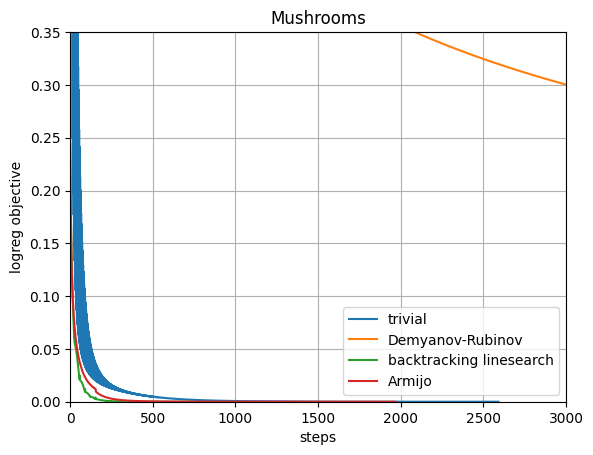

In [94]:
plt.title('Mushrooms')
plt.plot(losses_trivial, label='trivial')
plt.plot(losses_dr, label='Demyanov-Rubinov')
plt.plot(losses_ls, label='backtracking linesearch')
plt.plot(losses_armijo, label='Armijo')
plt.legend()
plt.grid()
plt.xlabel('steps')
plt.ylabel('logreg objective')
plt.ylim(0, 0.35)
plt.xlim(0, 3000)
plt.show();

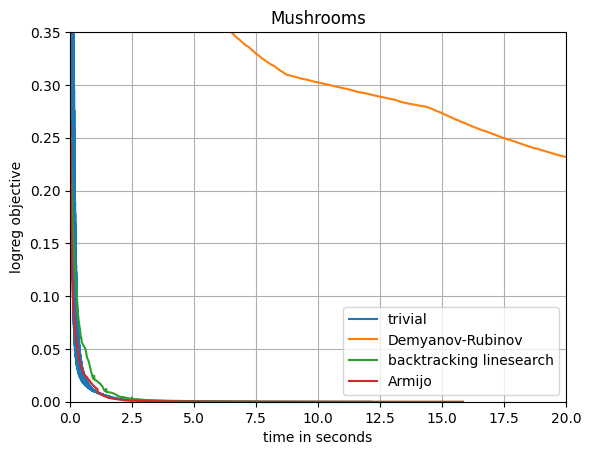

In [97]:
plt.title('Mushrooms')
plt.plot(times_trivial, losses_trivial, label='trivial')
plt.plot(times_dr, losses_dr, label='Demyanov-Rubinov')
plt.plot(times_ls, losses_ls, label='backtracking linesearch')
plt.plot(times_armigo, losses_armijo, label='Armijo')
plt.legend()
plt.grid()
plt.xlabel('time in seconds')
plt.ylabel('logreg objective')
plt.ylim(0, 0.35)
plt.xlim(0, 20)
plt.show();